# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
import os
import time
import torch

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.utils import data
from torch.backends import cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io
from sklearn import metrics

%matplotlib inline
cudnn.benchmark = True

## Casting para o dispositivo correto

Como usaremos processamento vetorial principalmente em GPUs para aprendizado profundo, primeiramente é possível verificar se há uma GPU disponível com o trecho de código abaixo, armazenando os tensores nos dispositivos apropriados.

In [ ]:
# Verificando se temos GPU/CUDA
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print(device)

cuda


# Intro MLP

## Neurônios e a camada `nn.Linear`

A camada Linear do Pytorch ([nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)) é responsável por aplicar uma transformação linear no dado de entrada. Esta camada recebe como parâmetro a dimensão (número de *features*) da entrada e da saída (que na verdade, representa o número de neurônios dessa camada). Por padrão o bias já é incluído. **Um** perceptron pode ser facilmente representado como a seguir, desconsiderando a função de ativação:

```
linear = nn.Linear(in_dimension, 1)
```
Mas de uma forma geral, uma camada Linear com diversas *features* de entrada e diversas *features* de saída pode ser representada como:
```
nn.Linear(in_features, out_features)
```
![](./figs/nn_linear.png)

In [ ]:
linear = nn.Linear(2, 1)
print(linear)

Linear(in_features=2, out_features=1, bias=True)


Como é possível ver no código abaixo, o Pytorch já inicia os pesos da camada aleatoriamente.

In [ ]:
for name, param in linear.named_parameters():
    print(f'Parameter {name}:')
    print(f'  - {param.data}\n')

Parameter weight:
  - tensor([[0.3667, 0.3165]])

Parameter bias:
  - tensor([-0.2155])



O **forward** consiste em passar seu dado de entrada pela rede, gerando um resultado ao final. Considerando a camada linear instanciada anteriormente, o resultado do forward é o mesmo do somatório da multiplicação de seus pesos pelas respectivas entradas juntamente com o bias, ou seja:

$$f_w(x) = w_0 + w_1x_1 + w_2x_2 + \ldots + w_nx_n$$

No Pytorch, realizamos o **forward** chamando o objeto onde nossa rede/modelo está instanciada, conforme exemplo abaixo.

In [ ]:
linear = nn.Linear(2, 1)
X = torch.tensor([2.0, 3.0])

print('Using Linear:', linear(X))
print('Manual:', torch.sum(X * linear.weight) + linear.bias)  # .weight e .bias permite acessarmos os pesos e bias deste modelo

Using Linear: tensor([-0.8796], grad_fn=<ViewBackward0>)
Manual: tensor([-0.8796], grad_fn=<AddBackward0>)


In [ ]:
# Ao fazermos linear(X), estamos fazendo implicitamente uma chamada na função forward da Linear
print('Forward com chamada implícita:', linear(X))
print('Forward com chamada explícita:', linear.forward(X))

Forward com chamada implícita: tensor([-0.8796], grad_fn=<ViewBackward0>)
Forward com chamada explícita: tensor([-0.8796], grad_fn=<ViewBackward0>)


## Exemplo de uma rede neural simples (1 camada)

O código abaixo cria uma rede neural simples usando `nn.Linear` e implementa o fluxo de treinamento para essa rede, ou seja, faz o forward, calcula a loss, e otimiza seus pesos. Invista um pouco de tempo para entender a célula abaixo pois usaremos essa ideia para implementar a função de treino mais a frente.

In [ ]:
# Iremos criar dados que seguem a função y = 2x + 3
dataset = []
for x in range(10):
    dataset.append((x, 2*x + 3))  # tupla com (x, y)

In [ ]:
dataset

[(0, 3),
 (1, 5),
 (2, 7),
 (3, 9),
 (4, 11),
 (5, 13),
 (6, 15),
 (7, 17),
 (8, 19),
 (9, 21)]

In [ ]:
# Definiremos uma loss (erro quadrático -> (y - y_hat)^2)
def loss_fn(predict, label):
    return torch.pow(label - predict, 2)

In [ ]:
linear = nn.Linear(1, 1)  # camada linear com 1 feature de entrada (mais o bias) e uma de saída
linear.to(device)  # casting do linear para GPU

learning_rate = 0.01
print(f'Parâmetros iniciais: {list(linear.parameters())}\n')

for epoch in range(100):
    epoch_loss = 0

    for X, y in dataset:
        # Fazendo o casting dos dados para tensores na GPU
        X = torch.FloatTensor([X]).to(device)
        y = torch.FloatTensor([y]).to(device)

        y_pred = linear(X)  # etapa de forward
        loss = loss_fn(y_pred, y)  # calcula a loss
        epoch_loss += loss.item()

        # Etapa de backprop
        loss.backward()
        with torch.no_grad(): # não queremos fazer com que o pytorch anote as operações do backprop e acumule o gradiente
            for param in linear.parameters():
                param -= learning_rate * param.grad  # atualização dos parametros (pesos e bias) com base no gradiente
                param.grad.zero_()  # resetando o gradiente

    if (epoch + 1) % 10 == 0:
        print("Epoch {} - loss: {}".format(epoch + 1, epoch_loss))

print('\nParâmetros finais: ', list(linear.parameters()))

Parâmetros iniciais: [Parameter containing:
tensor([[0.3856]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.4026], device='cuda:0', requires_grad=True)]

Epoch 10 - loss: 4.50460103712976
Epoch 20 - loss: 1.556748233619146
Epoch 30 - loss: 0.5379995520925149
Epoch 40 - loss: 0.18592704602633603
Epoch 50 - loss: 0.06425447968649678
Epoch 60 - loss: 0.022205637258593924
Epoch 70 - loss: 0.007674068577216531
Epoch 80 - loss: 0.002651898903422989
Epoch 90 - loss: 0.0009164031071122736
Epoch 100 - loss: 0.00031670121279603336

Parâmetros finais:  [Parameter containing:
tensor([[2.0011]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.9897], device='cuda:0', requires_grad=True)]


In [ ]:
X = torch.FloatTensor([20]).to(device)
print(linear(X))  # forward do valor 20 para conferir resultado, saida deve ser aproximadamente = 2x+3 = 2*20+3 = 43

tensor([43.0114], device='cuda:0', grad_fn=<ViewBackward0>)


## O módulo `nn.Sequential`

Na prática, criaremos redes com diversas camadas. O bloco `nn.Sequential` permite agrupar as camadas de forma sequencial para que o forward seja realizado na ordem desejada. Veja um exemplo para um *Multilayer Perceptron (MLP)* abaixo.

In [ ]:
in_features = 28
out_features = 8

first_hidden_size = 64
second_hidden_size = 32

MLP = nn.Sequential(
    nn.Linear(in_features, first_hidden_size), nn.ReLU(),
    nn.Linear(first_hidden_size, second_hidden_size), nn.ReLU(),
    nn.Linear(second_hidden_size, out_features)
)

MLP = MLP.to(device)
print(MLP)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,856
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 8]             264
Total params: 4,200
Trainable params: 4,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [ ]:
test_data = torch.randn((10, 28)).to(device)  # 10 dados de input aleatórios com 28 features

output = MLP(test_data)  # forward da rede
print(output.size())

torch.Size([10, 8])


Informação sobre outras camadas lineares, como nn.Bilinear e nn.Identity, podem ser vistas na documentação: https://pytorch.org/docs/stable/nn.html#linear-layers

## Conjunto de Exercícios 1 - Implementação de uma MLP

Vamos agora treinar um MLP simples no dataset de [Breast Cancer da UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). A célula abaixo irá carregar os dados utilizando a biblioteca scikit-learn, que já possui o dataset pronto para utilizarmos.

- Neste exercício, não estamos interessados em trabalhar com dados de treino/teste, mas sim apenas estudar como definir uma rede neural de múltiplas camadas em PyTorch e realizar o treinamento dos seus pesos e viéses.

In [ ]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

print('Tamanho de X:', X.shape)
print('Dataype de X:', type(X), X.dtype)

print('\nTamanho de y:', y.shape)
print('Dataype de y:', type(y), y.dtype)

Tamanho de X: (569, 30)
Dataype de X: <class 'numpy.ndarray'> float64

Tamanho de y: (569,)
Dataype de y: <class 'numpy.ndarray'> int64


In [ ]:
# Convertendo os dados para tensores PyTorch e fazendo o casting para o dispositivo apropriado
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)

# Modificando o shape das anotações para ser um vetor (n, 1) para não gerar erros no cálculo da função de perda
# Isso é necessário pois os produtos internos feitos no PyTorch irá resultar em uma matriz (n, 1), ou seja, n-linhas
# onde cada linha terá um valor binário (classe daquela observação)
y = y.unsqueeze(dim=-1)  # dim=-1 representa a última dimensão do nosso vetor

# Exibindo o tamanho dos tensores
print('Tamanho de X:', X.shape)
print('Dataype de X:', type(X), X.dtype)

print('\nTamanho de y:', y.shape)
print('Dataype de y:', type(y), y.dtype)

Tamanho de X: torch.Size([569, 30])
Dataype de X: <class 'torch.Tensor'> torch.float32

Tamanho de y: torch.Size([569, 1])
Dataype de y: <class 'torch.Tensor'> torch.float32


In [ ]:
print('Labels dos dados:', torch.unique(y))

Labels dos dados: tensor([0., 1.], device='cuda:0')


1. Implemente na célula abaixo uma MLP, de nome **model**, utilizando o módulo `nn.Sequential`. A sua rede MLP deve possuir, pelo menos, uma camada oculta, usando uma ReLU como função de ativação entre as camadas.

    - Note que o nosso problema é um problema de classificação binária. Iremos utilizar uma função de perda do PyTorch que recebe como entrada a saída "crua" (*logits*) da sua rede neural. Sendo assim, não se preocupe em aplicar alguma transformação na saída (como uma sigmóide) para converter os valores para uma probabilidade, por exemplo.

In [ ]:
in_features = 30
out_features = 1

model = nn.Sequential(
    nn.Linear(in_features, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, out_features),
)

model.to(device)  # sempre é necessario fazer o casting da rede para jogá-la para GPU
print(MLP)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,984
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 1]              65
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


Abaixo, definimos uma loss e um otimizador usando o PyTorch. Não se preocupem como isso funciona agora, pois iremos ver em detalhes como definir e usar diferentes losses e otimizadores com o PyTorch.

In [ ]:
# Iremos utilizar a entropia cruzada binária como função de perda para o nosso problema
# Essa versão da BCE aceita como entrada a saída "crua" (logits) da sua rede neural.
# Outras versões, como a BCELoss aceita como entrada uma saída probabilística da sua rede neural (sigmoid ou softmax),
# sendo assim você deve colocar uma função de ativação depois do último nn.Linear do seu modelo.
# A versão BCEWithLogitsLoss implementa uma versão mais numericamente estável da loss, podemos observar isso na própria
# documentação do PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=bcewithlogitsloss#torch.nn.BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Iremos utilizar o pacote optim para definir um otimizador que irá atualizar os pesos do modelo para nós.
# Aqui, utilizaremos SGD - Gradiente Descendente Estocástico.
# O pacote optim contém muitos outros algoritmos de otimização, porém, em todos o primeiro parâmetro irá dizer para os
# otimizadores quais tensores (com requires_grad=True) do nosso modelo ele deverá otimizar.
import torch.optim as optim

learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Abaixo teremos um loop de treinamento típico de PyTorch. Não precisa modificar em nada essa funçao, porém estude ela mesmo assim, já que usaremos esse fluxo como template para treinamento de outros modelos mais a frente no curso.

In [ ]:
# Aqui iremos criar uma lista de loss para cada época
loss_list = []

# Iterando sobre as épocas
n_epochs = 500
for epoch in range(n_epochs):
    preds = model(X)
    loss = criterion(preds, y)

    # Salvando a loss da iteração atual (para plots futuros)
    loss_list.append(loss.item())

    # Antes de fazermos o backward pass, iremos zerar o gradiente de todos os tensores
    # atrelados ao otimizador utilizando a chamada de função .zero_grad() do nosso otimizador.
    # Faremos isso pois os gradientes são acumulados, sempre que chamamos .backward(), em buffers nos
    # tensores que representam os pesos dos nossos modelos, ou seja, não são sobrescritos.
    # Para mais detalhes, você pode dar uma olhada na documentação do torch.autograd.backward
    optimizer.zero_grad()

    # Realizando o backward pass, ou seja, computando os gradientes da nossa função de perda
    # com respeito aos parâmetros (pesos) do nosso modelo
    loss.backward()

    # Chamando a função .step() do nosso otimizador para realizar um "passo" na otimização.
    # Nesse caso, o "passo" será realizar o cálculo que vimos do gradiente descendente
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.5f}')

Epoch 10: loss = 0.78376
Epoch 20: loss = 0.68751
Epoch 30: loss = 0.56526
Epoch 40: loss = 0.49223
Epoch 50: loss = 0.46643
Epoch 60: loss = 0.44964
Epoch 70: loss = 0.43471
Epoch 80: loss = 0.42174
Epoch 90: loss = 0.41075
Epoch 100: loss = 0.40026
Epoch 110: loss = 0.39029
Epoch 120: loss = 0.38113
Epoch 130: loss = 0.37315
Epoch 140: loss = 0.36614
Epoch 150: loss = 0.35966
Epoch 160: loss = 0.35368
Epoch 170: loss = 0.34808
Epoch 180: loss = 0.34284
Epoch 190: loss = 0.33793
Epoch 200: loss = 0.33332
Epoch 210: loss = 0.32899
Epoch 220: loss = 0.32490
Epoch 230: loss = 0.32105
Epoch 240: loss = 0.31740
Epoch 250: loss = 0.31394
Epoch 260: loss = 0.31065
Epoch 270: loss = 0.30752
Epoch 280: loss = 0.30454
Epoch 290: loss = 0.30169
Epoch 300: loss = 0.29896
Epoch 310: loss = 0.29635
Epoch 320: loss = 0.29385
Epoch 330: loss = 0.29145
Epoch 340: loss = 0.28913
Epoch 350: loss = 0.28689
Epoch 360: loss = 0.28474
Epoch 370: loss = 0.28265
Epoch 380: loss = 0.28066
Epoch 390: loss = 0.2

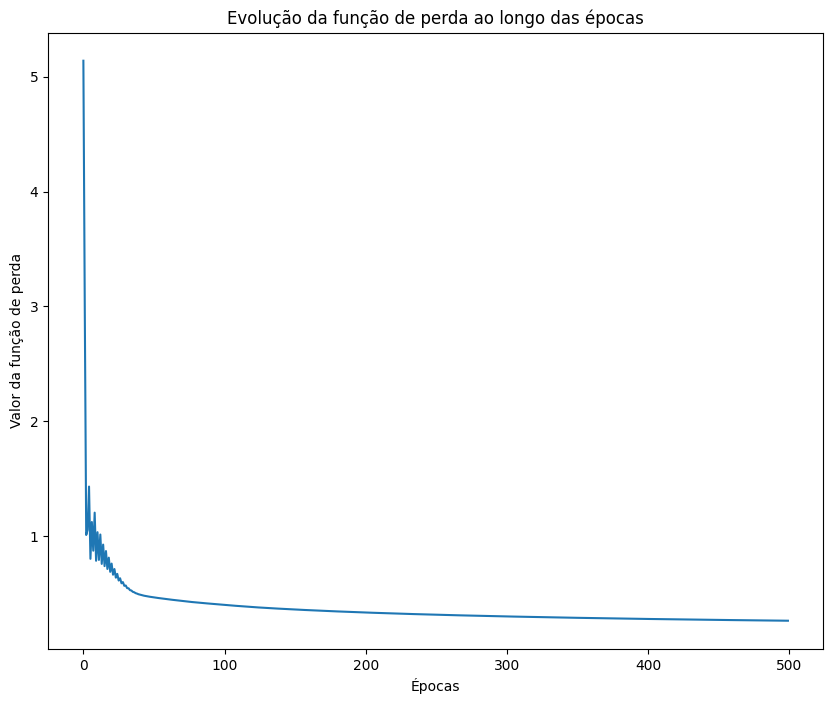

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Evolução da função de perda ao longo das épocas')
ax.set_ylabel('Valor da função de perda')
ax.set_xlabel('Épocas')
ax.plot(np.asarray(loss_list))

plt.show()

## Conjunto de Exercícios 2 - Implementação de uma MLP utilizando objetos

- Aqui, iremos repetir o mesmo procedimento feito anteriormente. Porém, iremos adotar uma implementação baseada no paradigma de orientação à objetos, que será muito importante em módulos futuros para definir modelos mais complexos e manter o código organizado.

    - Abaixo teremos um código onde a classe MLP receberá quantas `features` teremos de entrada e saída, qual o tamanho das camadas ocultas, e quantas camadas ocultas iremos ter. Uma assinatura diferente para o `__init__` que você pode optar é `__init__(self, in_features, out_features, hidden_sizes)`, onde `hidden_sizes` representa uma lista com o tamanho de cada camada oculta, definindo assim em uma só variável o número de camadas ocultas e suas dimensões. Sinta-se livre para modificar o código e experimentar com ambas opções.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_size, num_layers):
        # Essa linha é obrigatória quando formos definir qualquer modelo em PyTorch dessa forma.
        # Uma chamada equivalente é: super(self, MLP).__init__(), mas podemos omitir "self" e o nome da classe.
        super().__init__()

        # Implemente aqui o seu modelo (pode utilizar Sequential ou definir cada camada de forma separada)

        hidden_layers = []
        for _ in range(num_layers - 1):  # lembre-se que a primeira Linear já cria uma camada oculta
            layer = nn.Linear(hidden_size, hidden_size)
            hidden_layers.append(layer)
            hidden_layers.append(nn.ReLU())

        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size), nn.ReLU(),
            *hidden_layers,
            nn.Linear(hidden_size, out_features)
        )

    # Devemos implementar a passagem do dado ao longo da nossa rede.
    # Para isso, sobreescrevemos o método forward, definido pela classe herdada: nn.Module.
    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
class AlternativeMLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes):
        super().__init__()

        self.relu = nn.ReLU()
        self.input_layer = nn.Linear(in_features, hidden_sizes[0])
        self.output_layer = nn.Linear(hidden_sizes[-1], out_features)

        hidden_layers = []
        for i in range(len(hidden_sizes) - 1):
            layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            hidden_layers.append(layer)
            hidden_layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*hidden_layers)

    def forward(self, x):
        output = self.relu(self.input_layer(x))
        output = self.hidden_layers(output)
        output = self.output_layer(output)
        return output

In [ ]:
in_features = 30
out_features = 1

# Instancie o seu modelo aqui
model = MLP(in_features, out_features, hidden_size=64, num_layers=2)

model = model.to(device)
print(MLP)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,984
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 1]              65
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


- Agora iremos treinar o modelo normalmente.

In [ ]:
learning_rate = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Aqui iremos criar uma lista de loss para cada época
loss_list = []

# Iterando sobre as épocas
n_epochs = 500
for epoch in range(n_epochs):
    preds = model(X)
    loss = criterion(preds, y)

    # Salvando a loss da iteração atual (para plots futuros)
    loss_list.append(loss.item())

    # Antes de fazermos o backward pass, iremos zerar o gradiente de todos os tensores
    # atrelados ao otimizador utilizando a chamada de função .zero_grad() do nosso otimizador.
    # Faremos isso pois os gradientes são acumulados, sempre que chamamos .backward(), em buffers nos
    # tensores que representam os pesos dos nossos modelos, ou seja, não são sobrescritos.
    # Para mais detalhes, você pode dar uma olhada na documentação do torch.autograd.backward
    optimizer.zero_grad()

    # Realizando o backward pass, ou seja, computando os gradientes da nossa função de perda
    # com respeito aos parâmetros (pesos) do nosso modelo
    loss.backward()

    # Chamando a função .step() do nosso otimizador para realizar um "passo" na otimização.
    # Nesse caso, o "passo" será realizar o cálculo que vimos do gradiente descendente
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.5f}')

Epoch 10: loss = 0.69283
Epoch 20: loss = 0.51928
Epoch 30: loss = 0.39598
Epoch 40: loss = 0.36977
Epoch 50: loss = 0.36173
Epoch 60: loss = 0.35554
Epoch 70: loss = 0.35035
Epoch 80: loss = 0.34590
Epoch 90: loss = 0.34181
Epoch 100: loss = 0.33808
Epoch 110: loss = 0.33465
Epoch 120: loss = 0.33147
Epoch 130: loss = 0.32855
Epoch 140: loss = 0.32581
Epoch 150: loss = 0.32321
Epoch 160: loss = 0.32074
Epoch 170: loss = 0.31840
Epoch 180: loss = 0.31616
Epoch 190: loss = 0.31400
Epoch 200: loss = 0.31192
Epoch 210: loss = 0.30991
Epoch 220: loss = 0.30797
Epoch 230: loss = 0.30613
Epoch 240: loss = 0.30434
Epoch 250: loss = 0.30262
Epoch 260: loss = 0.30095
Epoch 270: loss = 0.29932
Epoch 280: loss = 0.29772
Epoch 290: loss = 0.29617
Epoch 300: loss = 0.29465
Epoch 310: loss = 0.29315
Epoch 320: loss = 0.29170
Epoch 330: loss = 0.29029
Epoch 340: loss = 0.28891
Epoch 350: loss = 0.28757
Epoch 360: loss = 0.28625
Epoch 370: loss = 0.28496
Epoch 380: loss = 0.28370
Epoch 390: loss = 0.2

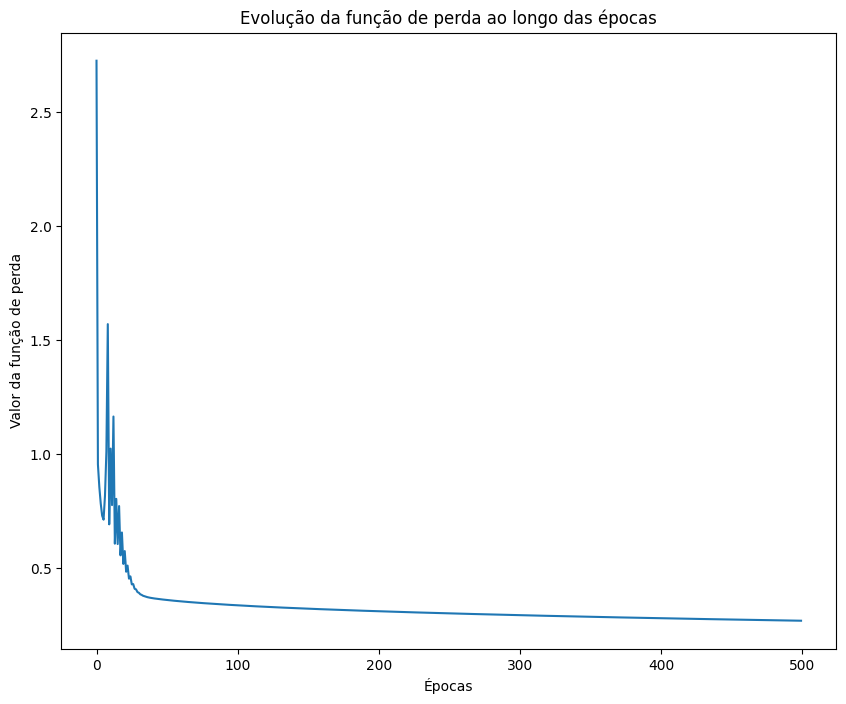

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Evolução da função de perda ao longo das épocas')
ax.set_ylabel('Valor da função de perda')
ax.set_xlabel('Épocas')
ax.plot(np.asarray(loss_list))

plt.show()